## 1. Import packages

In [0]:
import os
import math
from urllib.request import urlretrieve
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torchvision.models import vgg16
import torchvision.transforms as T
from torch.autograd.gradcheck import zero_gradients


## 2. Define some useful functions

In [0]:
def download(url, filename=None):
    if filename is None:
        filename = url.split('/')[-1]
    if not os.path.exists(filename):
        print('Downloading {} from {}...'.format(filename, url))
        urlretrieve(url, filename=filename)

def imshow(img, mean, std):
    z = img.cpu() * torch.tensor(std).view(3, 1, 1)
    z = z + torch.tensor(mean).view(3, 1, 1)

    pimg = T.ToPILImage(mode='RGB')(z)

    plt.imshow(np.asarray(pimg))

loss_fn = torch.nn.CrossEntropyLoss()

## Download images and indices that are required for our model

In [0]:
# FGSM
download('https://github.com/Harry24k/FGSM-pytorch/raw/master/data/giant_panda/1.jpg', filename='giant_panda.jpg')
download('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')

# DeepFool
download('https://github.com/LTS4/DeepFool/raw/master/Python/test_im1.jpg')
download('https://github.com/LTS4/DeepFool/raw/master/Python/test_im2.jpg')
download('https://github.com/LTS4/DeepFool/raw/master/Python/synset_words.txt')

## 3. Get input image



In [0]:
imsize = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transforms = T.Compose([
        T.Resize(imsize),
        T.CenterCrop(imsize),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])

img = Image.open('giant_panda.jpg')
img = transforms(img)
img = img.cuda()

## 4. Get pretrained model
 

In [0]:
model = vgg16(pretrained=True)
model = model.cuda()
model = model.eval()
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

## 5. Let's classify our image with the pretrained model first!

predicted label before FGSM: giant_panda with confidence of 0.98


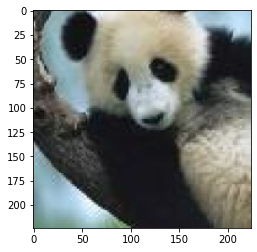

In [0]:
outputs = model.forward(img.unsqueeze(0))
outputs = torch.softmax(outputs, 1)
confidence, y_pred = torch.max(outputs.data, 1)
print('predicted label before FGSM: %s with confidence of %.2f'%(idx2label[y_pred], confidence.item()))
imshow(img, mean, std)

## Attack Methods

### 1. FGSM

In [0]:
def fgsm(img, model, loss_fn, epsilon=0.007):
    model = model.eval()
    img_pert = img.clone()
    img_pert = img_pert.requires_grad_()

    outputs = model.forward(img_pert.unsqueeze(0))

    outputs = torch.softmax(outputs, 1)

    probs, y_pred = torch.topk(outputs.data, 1, dim=1)
    y_pred = y_pred.squeeze(1)

    loss = loss_fn(outputs, y_pred)
    
    loss.backward()

    img_pert.data.copy_(img.data + epsilon * torch.sign(img_pert.grad))

    return img_pert

### 2. DeepFool

In [0]:
def deepfool(img, model, num_k=10, overshoot=0.02, max_iter=50):
    model = model.eval()
    pert_img = img.clone()
    pert_img = pert_img.requires_grad_()

    outputs = model.forward(pert_img.unsqueeze(0))
    _, indices = torch.topk(outputs.data, num_k, dim=1)

    k_hat = indices[0][0] # class index img belongs to
    
    label = k_hat

    r_tot = torch.zeros_like(img)
    i = 0
    while k_hat == label and i < max_iter:
        zero_gradients(pert_img)
        outputs[0][k_hat].backward()
        grad_k_hat = pert_img.grad.data.clone()

        d = math.inf # d: distance from x_0 to a hyperplane
        for c in range(1, num_k):
            k = indices[0][c] # class index we want perturbed img belongs to

            f_k = outputs[0][k_hat] - outputs[0][k]

            outputs = model.forward(pert_img.unsqueeze(0))
            zero_gradients(pert_img)
            outputs[0][k].backward()
            grad_k = pert_img.grad.data.clone()
            grad_f_k = grad_k_hat - grad_k

            d_k = abs(f_k) / torch.norm(grad_f_k) # Note: torch.norm computes the sqrt root, i.e., ||w||_2, rather than ||w||_x^2
            d_k = d_k.item()

            if d_k < d:
                d = d_k
                grad_f = grad_f_k

        r_i = - (d + 1e-4) * grad_f / torch.norm(grad_f) # Added 1e-4 for numerical stability
        r_tot.add_(r_i)


        pert_img.data.copy_(img.data + (1 + overshoot) * r_tot)
        outputs = model.forward(pert_img.unsqueeze(0))
        _, indices = torch.topk(outputs.data, num_k, dim=1)

        k_hat = indices[0][0] # class index img belongs to

        i += 1

    r_tot = (1 + overshoot) * r_tot

    return pert_img #, r_tot


## 6. Apply FGSM to our image

In [0]:
# Apply FGSM to our image


img_fgsm = fgsm(img, model, loss_fn)
img_deepfool = deepfool(img, model)

## 7. Let's classify our image again and see if the prediction fails

predicted label after FGSM: indri (with confidence of 0.31)
predicted label after DeepFool: indri (with confidence of 0.41)


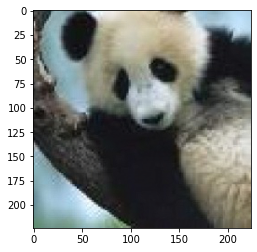

In [0]:
# Classify our image again
def analyze(img, model, alg_name, mean=mean, std=std):
    outputs = model.forward(img.unsqueeze(0))
    outputs = torch.softmax(outputs, 1)
    confidence, y_pred = torch.max(outputs.data, 1)
    print('predicted label after %s: %s (with confidence of %.2f)'%(alg_name, idx2label[y_pred], confidence.item()))
    imshow(img, mean, std)

analyze(img_fgsm, model, "FGSM")
analyze(img_deepfool, model, "DeepFool")